In [33]:
import numpy as np
from pprint import pprint
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
np.random.seed(678)

In [6]:
# Example from the website
x1 = [0, 1, 1, 2, 2, 2]
x2 = [0, 0, 1, 1, 1, 0]
y = np.array([0, 0, 0, 1, 1, 0])

def partition(a):
    return {c: (a==c).nonzero()[0] for c in np.unique(a)}

def entropy(s):
    res = 0
    val, counts = np.unique(s, return_counts=True)
    freqs = counts.astype('float')/len(s)
    for p in freqs:
        if p != 0.0:
            res -= p * np.log2(p)
    return res

def mutual_information(y, x):

    res = entropy(y)

    # We partition x, according to attribute values x_i
    val, counts = np.unique(x, return_counts=True)
    freqs = counts.astype('float')/len(x)

    # We calculate a weighted average of the entropy
    for p, v in zip(freqs, val):
        res -= p * entropy(y[x == v])

    return res

def is_pure(s):
    return len(set(s)) == 1

def recursive_split(x, y):
    # If there could be no split, just return the original set
    if is_pure(y) or len(y) == 0:
        return y

    # We get attribute that gives the highest mutual information
    gain = np.array([mutual_information(y, x_attr) for x_attr in x.T])
    selected_attr = np.argmax(gain)

    # If there's no gain at all, nothing has to be done, just return the original set
    if np.all(gain < 1e-6):
        return y


    # We split using the selected attribute
    sets = partition(x[:, selected_attr])

    res = {}
    for k, v in sets.items():
        y_subset = y.take(v, axis=0)
        x_subset = x.take(v, axis=0)

        res["x_%d = %d" % (selected_attr, k)] = recursive_split(x_subset, y_subset)

    return res

X = np.array([x1, x2]).T
pprint(recursive_split(X, y))

{'x_0 = 0': array([0]),
 'x_0 = 1': array([0, 0]),
 'x_0 = 2': {'x_1 = 0': array([0]), 'x_1 = 1': array([1, 1])}}


In [14]:
!open .

In [27]:
df = pd.read_csv('data_banknote_authentication.csv',
                 names=['variance','skewness','kurtosis','entropy','class'])

In [28]:
df.describe()

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
variance    1372 non-null float64
skewness    1372 non-null float64
kurtosis    1372 non-null float64
entropy     1372 non-null float64
class       1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


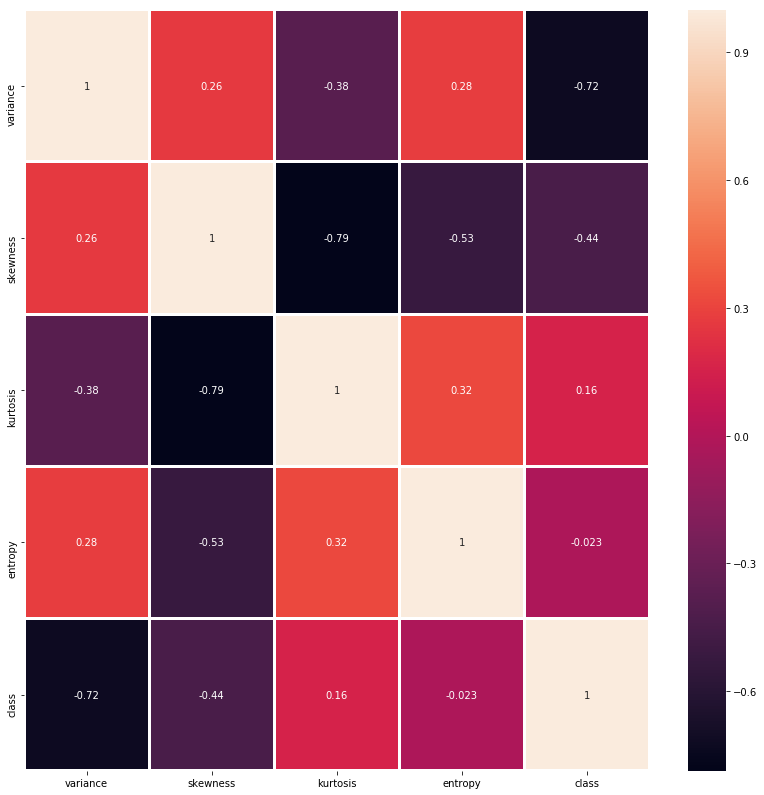

In [38]:
plt.subplots(figsize=(14,14)) 
sns.heatmap(df.corr(),annot=True,linewidths=2)

In [39]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

In [40]:
# test Gini values
print(gini_index([[[1, 1], [1, 0]], [[1, 1], [1, 0]]], [0, 1]))
print(gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0, 1]))

0.5
0.0


In [41]:
# 

In [49]:
#  Example from med
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
Y = df['class']
X = df.loc[:, df.columns != 'class']
dtree.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found